## PDS API demo
# Visualization of Osiris-Rex OVIRS spectrometer observations of asteroid BENNU

The purpose of this notebook is to demostrate how the PDS web API can be used to access the PDS data for a scientific use case.

The documention of the PDS web API is available on https://nasa-pds.github.io/pds-api/

This notebook is available on https://github.com/NASA-PDS/pds-api-notebook

 
<b>WARNING:</b> This notebook is a demo and not a real scientific use case. It might contain mistakes in the way the data is used or displayed.

In [35]:
from __future__ import print_function
from pprint import pprint
import time
import matplotlib.pyplot as plt
from astropy.io import fits

The PDS API is accessed using a python client library documented on https://nasa-pds.github.io/pds-api-client/

In [36]:
import pds.api_client as pds_api

## Use the PDS demo web API server 

Connect to the demo server. See User Interface of the web API: http://pds-gamma.jpl.nasa.gov/api/swagger-ui.html

<b>Note: </b> this piece of code will be wrapped into a helper function so that 1 line will be enough to connect to the API using a default host

In [37]:
configuration = pds_api.Configuration()

# demo server
configuration.host = 'http://pds-gamma.jpl.nasa.gov/api/'

api_client = pds_api.ApiClient(configuration)


## List requestable properties

Available properties can be identified with request

In [48]:
products_api = pds_api.ProductsApi(api_client)

api_response = products_api.products(only_summary=True)
print(f"Available properties are {', '.join(api_response.summary.properties[1:10])}...")

Available properties are pds:Modification_Detail.pds:modification_date, ops:Label_File_Info.ops:md5_checksum, pds:Internal_Reference.pds:lidvid_reference, vid, insight:Observation_Information.insight:start_solar_longitude, pds:Observing_System_Component.pds:type, pds:Stream_Text.pds:description, msn:Mission_Information.msn:product_type_name, ops:Data_File_Info.ops:md5_checksum...


## Get observations around specific spot (lat=12, lon=24) with distance to bennu closer than 4 km

Get the result found in part1 by directly posting the search criteria to the API

We can use `ProductsApi.products` with argument `q=`.

The query syntax is described in the PDS API specification. It uses the following operators:
- comparison: lt, le, ...
- boolean: and, or, not
- groups: (, )

See https://github.com/NASA-PDS/pds-api/blob/master/docs/spec/pds-api-specification.md#query-syntax for detailed syntax.

We request the FITS data file url from the API in the `field=` argument.

In [47]:
start_time = time.time() 

criteria += " ( (ref_lid_target eq urn:nasa:pds:context:target:asteroid.101955_bennu)"
criteria += " and (ref_lid_instrument eq urn:nasa:pds:context:instrument:ovirs.orex)"
criteria += " and (orex:spatial.orex:target_range lt 4.0)"
criteria += " and (orex:spatial.orex:latitude ge 9.0) and (orex:spatial.orex:latitude le 15.0)"
criteria += " and (orex:spatial.orex:longitude ge 21.0) and (orex:spatial.orex:longitude le 27.0))"

properties_of_interest = ['orex:spatial.orex:latitude', 'orex:spatial.orex:longitude', 'ref_lid_instrument', 'orex:spatial.orex:target_range', 'ops:Data_File_Info.ops:file_ref']

closer_products = products_api.products(q=criteria, fields=properties_of_interest)

elapsed = time.time() - start_time
print(f'retrieved {len(closer_products.data)} products in {elapsed} seconds')

retrieved 4 products in 0.3840057849884033 seconds


## Structure of the reponse

The responses are JSON objects, as follow

In [46]:
pprint(closer_products.data[0])

{'description': None,
 'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204128s567_ovr_scil2.fits::1.0',
 'investigations': [{'description': None,
                     'href': 'http://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex',
                     'title': None,
                     'type': None}],
 'metadata': {'creation_date_time': '2019-10-23T19:05:39.752Z',
              'label_url': 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204128S567_ovr_scil2.xml',
              'update_date_time': None,
              'version': '1.0'},
 'observing_system_components': [{'description': None,
                                  'href': 'http://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:pds

### Check that we have the right lidvids

In [41]:
lidvids = [product.id for product in closer_products.data]
print(f'The lidvids of the selected products are {lidvids}')

The lidvids of the selected products are ['urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204128s567_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204129s468_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204130s368_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204131s368_ovr_scil2.fits::1.0']


### Extract the links to the data files

In [51]:
data_files = [product.properties['ops:Data_File_Info.ops:file_ref'] for product in closer_products.data]
print(f"product data file url: {data_files}")

product data file url: ['https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204128S567_ovr_scil2.fits', 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204129S468_ovr_scil2.fits', 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204130S368_ovr_scil2.fits', 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204131S368_ovr_scil2.fits']


## Plot the data (FITS files)

Plot the spectra of the 4 observations on the same figure, one figure per dimension of the instrument.


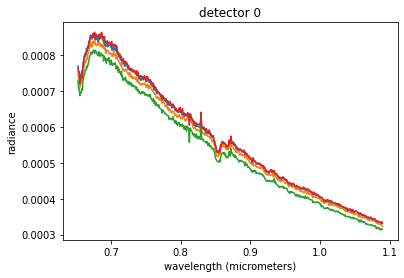

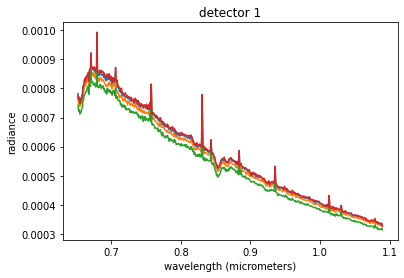

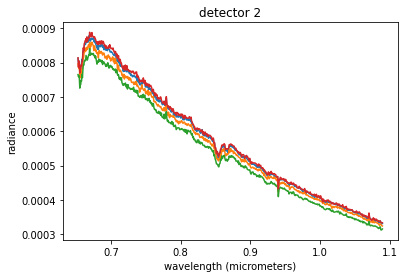

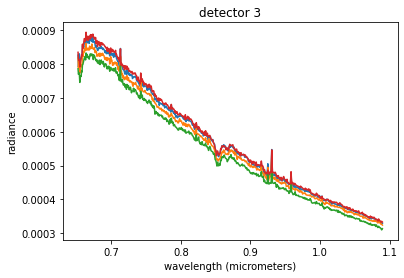

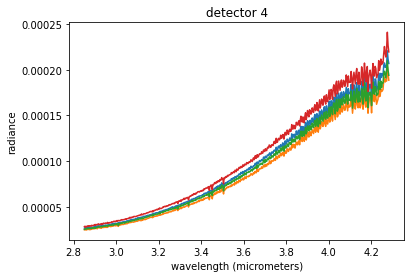

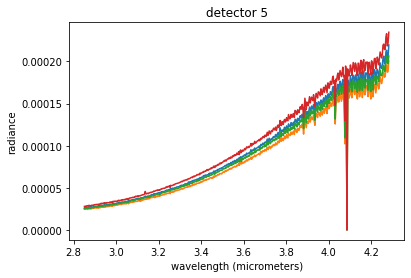

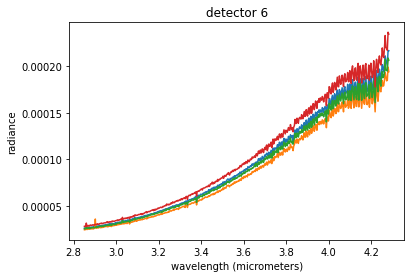

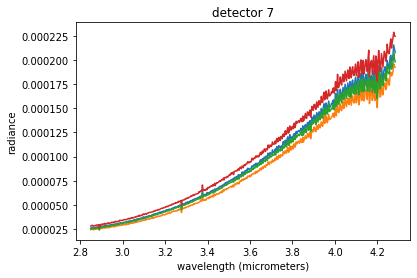

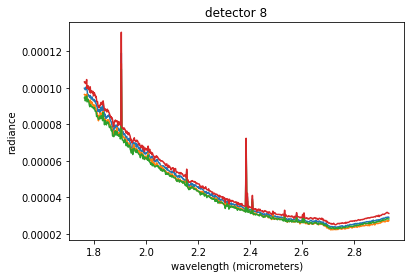

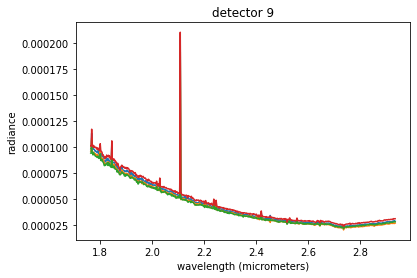

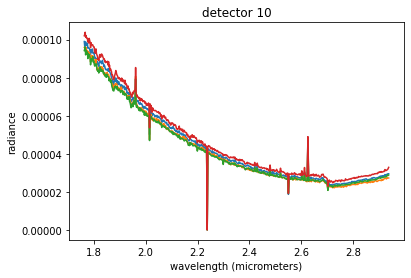

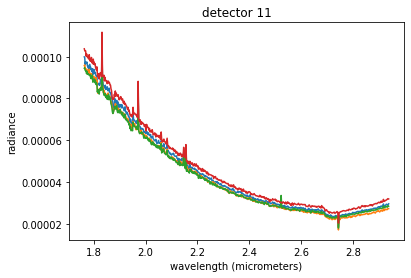

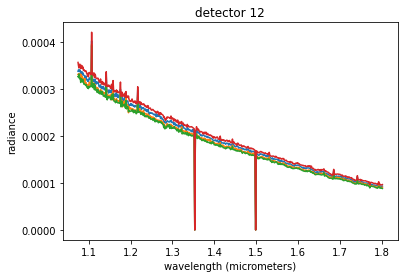

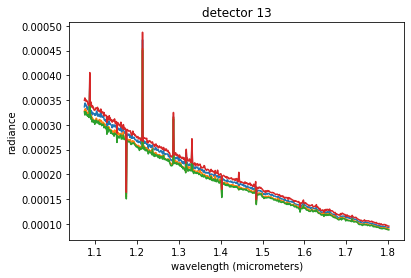

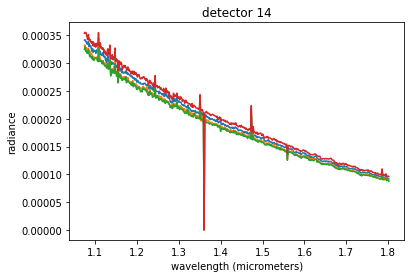

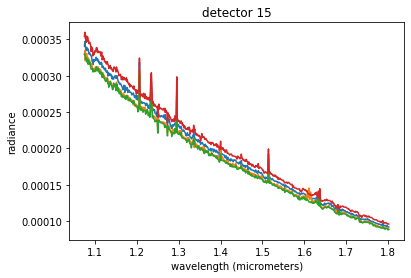

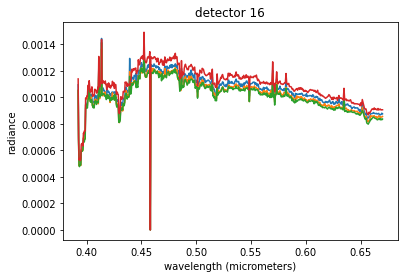

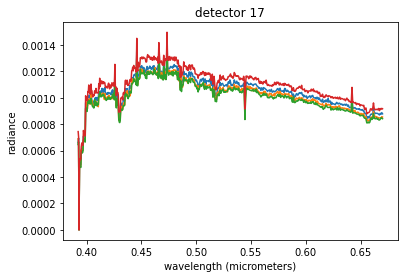

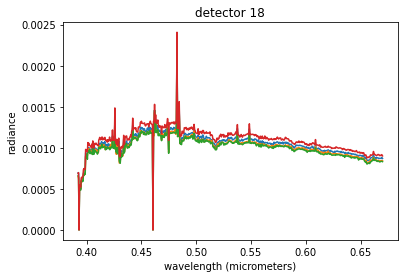

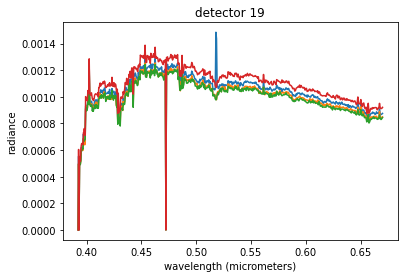

In [43]:
hduls = [fits.open(data_file) for data_file in data_files]

for i in range(20): # for each dimension of the instrument
    fig, ax = plt.subplots()
    ax.set_title(f'detector {i}')
    for hdul in hduls: # for each observation
        ax.plot(hdul[2].data[0, i, :], hdul[0].data[0, i, :])
    ax.set_xlabel('wavelength (micrometers)')
    ax.set_ylabel('radiance')